## Wine Quality Analysis (Clustering + PCA)

-- Importing dependencies --

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

-- Importing dataset --

In [191]:
# -- Import in pandas dataframe --
df = pd.read_csv('winequality-white.csv',delimiter=';')

In [192]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [193]:
df.shape

(4898, 12)

-- Data Preprocessing --

In [194]:
# -- Removing target column (for unsupervised learning problem) --
df.drop('quality', axis=1, inplace=True)

In [195]:
# -- Check for null values --
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [196]:
# -- Check for duplicates --
df.duplicated().value_counts()

,count
False,3961
True,937


In [197]:
# -- Remove duplicate rows --
df.drop_duplicates(inplace=True)

In [198]:
# -- Check for datatypes --
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3961 entries, 0 to 4897
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3961 non-null   float64
 1   volatile acidity      3961 non-null   float64
 2   citric acid           3961 non-null   float64
 3   residual sugar        3961 non-null   float64
 4   chlorides             3961 non-null   float64
 5   free sulfur dioxide   3961 non-null   float64
 6   total sulfur dioxide  3961 non-null   float64
 7   density               3961 non-null   float64
 8   pH                    3961 non-null   float64
 9   sulphates             3961 non-null   float64
 10  alcohol               3961 non-null   float64
dtypes: float64(11)
memory usage: 371.3 KB


In [199]:
# -- Scaling columns --
scalar = StandardScaler()
scaled = scalar.fit_transform(df)
df_scaled =pd.DataFrame(scaled,columns=df.columns)

-- Correlation Analysis --

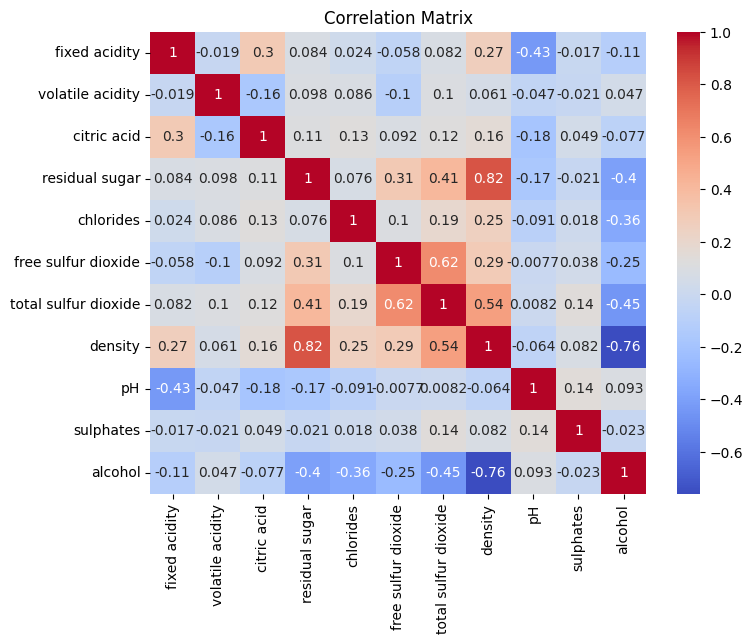

In [200]:
# -- Making Correlation Matrix --
corr_matrix = df_scaled.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

The **`density`** column is highly correlated with the **`alcohol`** and **`residual sugar`** columns. Ideally, it should be removed from `df_scaled`; however, doing so in practice reduces the silhouette score.


-- Training Model --

In [201]:
# -- Elbow method --
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i,random_state=2)
    km.fit_predict(df_scaled)
    wcss.append(km.inertia_)

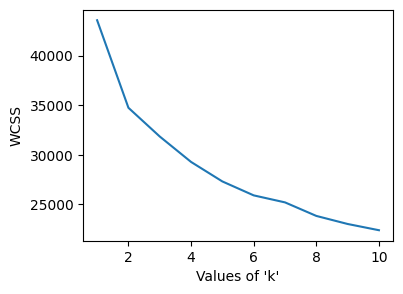

In [202]:
# -- Plotting elbow curve --
plt.figure(figsize=(4, 3))
plt.plot(range(1,11),wcss)
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.show()

Selecting k = 2 for clustering

In [203]:
# -- Training Model --
X = df_scaled.to_numpy()
km = KMeans(n_clusters=2)
y_means = pd.DataFrame(km.fit_predict(X))

In [204]:
# -- Clustering Output --
y_means.value_counts()

,count
0,
1,2494
0,1467


-- Principal Component Analysis --

In [205]:
# -- Using PCA for data visualization --
pca = PCA(n_components=3)
reduced_X = pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2','PCA3'])

In [210]:
reduced_X.head(2)

,PCA1,PCA2,PCA3
0,3.862702,0.511138,0.906204
1,-0.511673,-0.436496,0.345879


In [214]:
# -- Transforming cluster centers --
centers = pca.transform(km.cluster_centers_)
centers

array([[ 1.94194143, -0.11182636,  0.03597201],
       [-1.14103652,  0.06570639, -0.02113626]])

In [224]:
# -- Plotting clusters --
data = reduced_X.copy()
data['cluster'] = y_means

plt.figure(figsize=(8, 6))
fig = px.scatter_3d(
    data, x='PCA1', y='PCA2', z='PCA3',
    color='cluster',
    title='Interactive Wine Clusters (3D PCA)',
    symbol='cluster'
)
fig.add_scatter3d(x=centers[:, 0], y=centers[:, 1], z=centers[:, 2],mode='markers', marker=dict(size=8, color='red', symbol='x'), name='Centroids')
fig.update_layout(width=500, height=400)
fig.show()

<Figure size 800x600 with 0 Axes>

-- Evaluaing Clusters --

In [231]:
# -- Silhouette Score --
from sklearn.metrics import silhouette_score
score = silhouette_score(X, y_means[0])
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.214
